<a href="https://colab.research.google.com/github/caiosilveiracw/lending-case/blob/main/lending_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Configurando o estilo do Seaborn
sns.set(style="whitegrid")

# Função para carregar os dados
def load_data():
    # Carregando os arquivos CSV
    from google.colab import files
    uploaded = files.upload()

    # Leitura dos arquivos CSV
    loans_data = pd.read_csv('loans.csv')
    clients_data = pd.read_csv('clients.csv')

    # Convertendo colunas de data
    loans_data['created_at'] = pd.to_datetime(loans_data['created_at'])
    clients_data['created_at'] = pd.to_datetime(clients_data['created_at'])
    clients_data['denied_at'] = pd.to_datetime(clients_data['denied_at'])

    # Adicionando coluna de ano e mês para facilitar no group by
    loans_data['year_month'] = loans_data['created_at'].dt.to_period('M')
    return loans_data, clients_data

loans_data, clients_data = load_data()


Saving clients.csv to clients (2).csv
Saving loans.csv to loans (2).csv


<ipython-input-17-1f460e8c37c1>:17: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  loans_data = pd.read_csv('loans.csv')


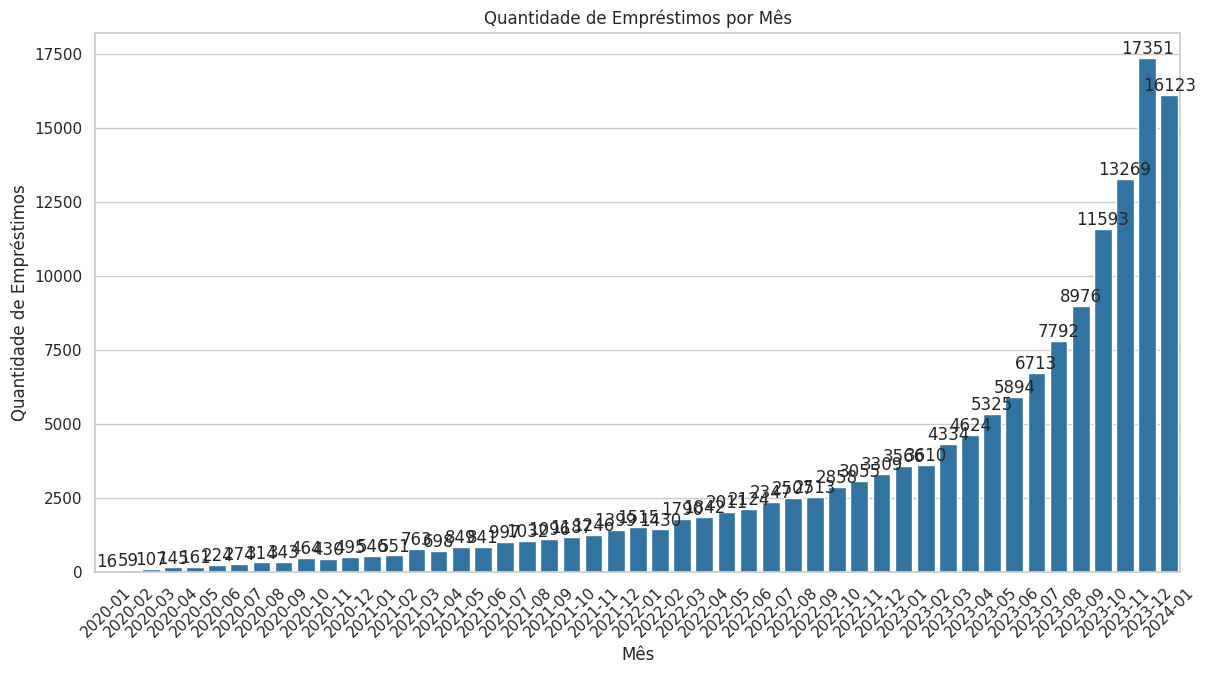

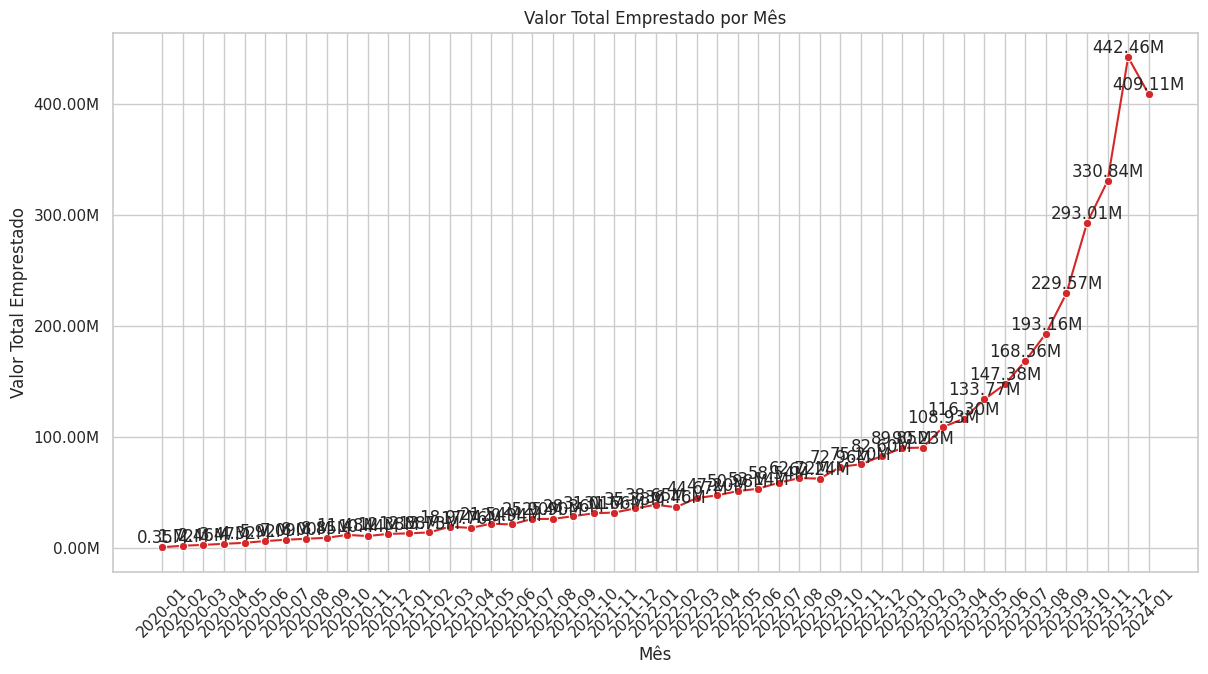

In [ ]:
# Melhor Mês para Emissão de Empréstimos
monthly_loan_data = loans_data.groupby('year_month').agg(
    quantidade_emprestimos=('loan_id', 'count'),
    valor_total_emprestado=('loan_amount', 'sum')
).reset_index()

# Gráfico 1: Quantidade de Empréstimos por Mês
plt.figure(figsize=(14, 7))
sns.barplot(x=monthly_loan_data['year_month'].astype(str), y=monthly_loan_data['quantidade_emprestimos'], color='tab:blue')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Empréstimos')
plt.title('Quantidade de Empréstimos por Mês')
plt.xticks(rotation=45)
# Adicionando rótulos nas barras
for index, value in enumerate(monthly_loan_data['quantidade_emprestimos']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()



# Importando função para formatação do eixo Y
from matplotlib.ticker import FuncFormatter

# Função para formatar os valores em milhões
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.2fM' % (x * 1e-6)

# Gráfico 2: Valor Total Emprestado por Mês
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_loan_data['year_month'].astype(str), y=monthly_loan_data['valor_total_emprestado'], color='tab:red', marker='o')
plt.xlabel('Mês')
plt.ylabel('Valor Total Emprestado')
plt.title('Valor Total Emprestado por Mês')
plt.xticks(rotation=45)

# Aplicando a formatação ao eixo Y
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionando rótulos nos pontos
for index, value in enumerate(monthly_loan_data['valor_total_emprestado']):
    plt.text(index, value, f'{value * 1e-6:.2f}M', ha='center', va='bottom')

plt.show()



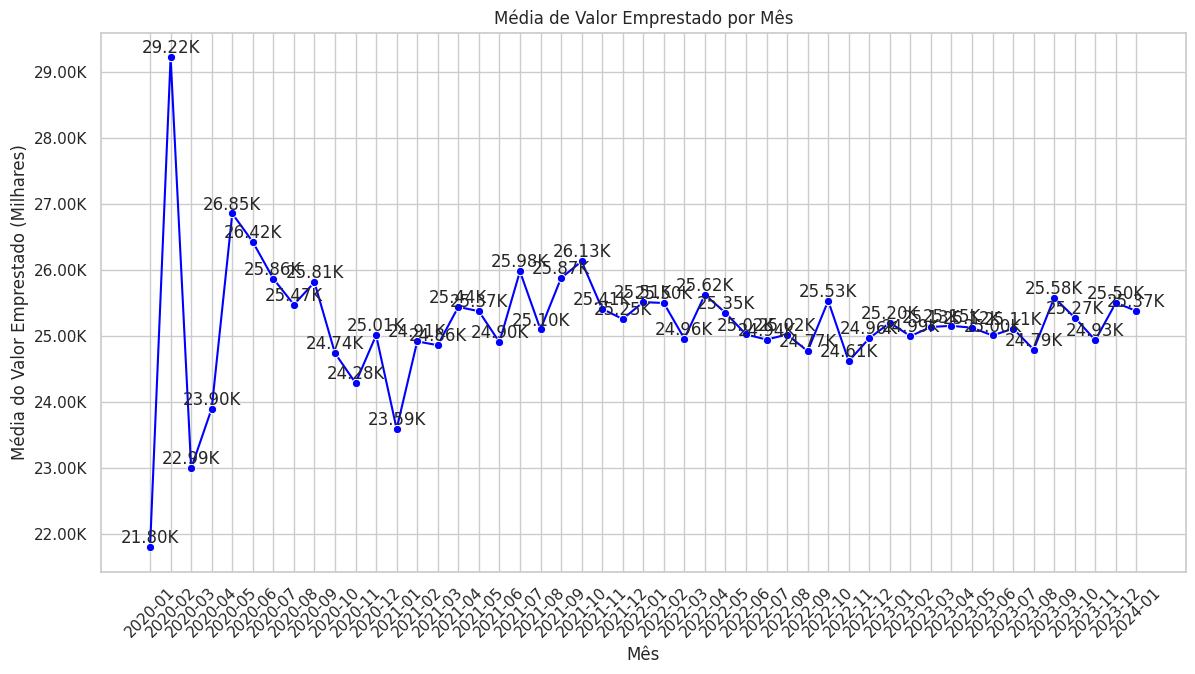

In [ ]:
# Média de Valor Emprestado por Mês

# Calculando a média do valor emprestado por mês
monthly_loan_data = loans_data.groupby('year_month').agg(
    total_loan_amount=('loan_amount', 'sum'),
    number_of_loans=('loan_id', 'count')
).reset_index()
monthly_loan_data['mean_loan_amount'] = monthly_loan_data['total_loan_amount'] / monthly_loan_data['number_of_loans']

# Função para formatar os valores em milhares
def thousands(x, pos):
    return '%1.2fK' % (x * 1e-3)

# Plotando os resultados
plt.figure(figsize=(14, 7))
sns.lineplot(x=monthly_loan_data['year_month'].astype(str), y=monthly_loan_data['mean_loan_amount'], marker='o', color='blue')
plt.xlabel('Mês')
plt.ylabel('Média do Valor Emprestado (Milhares)')
plt.title('Média de Valor Emprestado por Mês')
plt.xticks(rotation=45)

# Aplicando a formatação ao eixo Y
formatter = FuncFormatter(thousands)
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionando rótulos nos pontos
for index, value in enumerate(monthly_loan_data['mean_loan_amount']):
    plt.text(index, value, f'{value * 1e-3:.2f}K', ha='center', va='bottom')

plt.show()


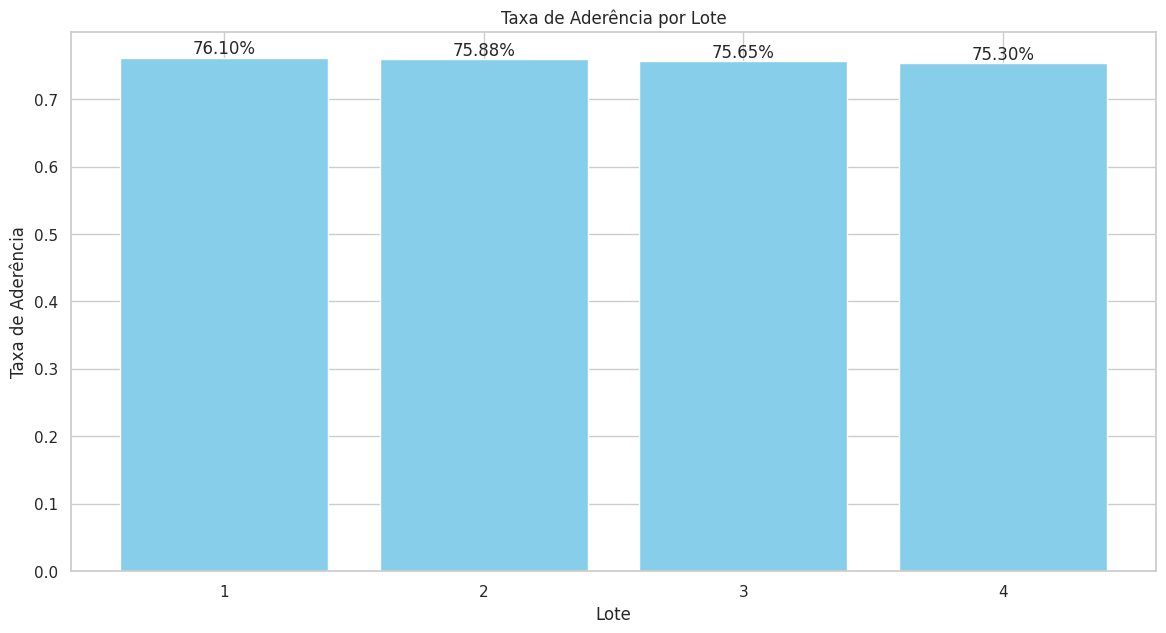

In [ ]:
# Melhor Lote em Termos de Aderência

# Filtrar clientes aprovados
approved_clients = clients_data[clients_data['status'] == 'approved']

# Agrupar clientes aprovados por lote
batch_adhesion = approved_clients.groupby('batch').agg(
    total_clients=('user_id', 'count')
).reset_index()

# Filtrar empréstimos realizados por clientes aprovados
loaned_clients = loans_data[loans_data['user_id'].isin(approved_clients['user_id'])]

# Contar clientes aprovados que tomaram empréstimos por lote
loaned_clients_by_batch = loaned_clients.merge(approved_clients[['user_id', 'batch']], on='user_id', how='left')
loaned_clients_count = loaned_clients_by_batch.groupby('batch').agg(
    clients_with_loans=('user_id', 'nunique')  # Contar clientes únicos que tomaram empréstimos
).reset_index()

# Mesclar dados de clientes aprovados com dados de clientes que tomaram empréstimos
batch_adhesion = batch_adhesion.merge(loaned_clients_count, on='batch', how='left')
batch_adhesion['clients_with_loans'].fillna(0, inplace=True)  # Substituir NaN por 0 para lotes sem empréstimos
batch_adhesion['adhesion_rate'] = batch_adhesion['clients_with_loans'] / batch_adhesion['total_clients']

# Plotando os resultados
plt.figure(figsize=(14, 7))
bars = plt.bar(batch_adhesion['batch'], batch_adhesion['adhesion_rate'], color='skyblue')
plt.xlabel('Lote')
plt.ylabel('Taxa de Aderência')
plt.title('Taxa de Aderência por Lote')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Configurando o eixo X para mostrar apenas inteiros

# Adicionando rótulos nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom')

plt.show()


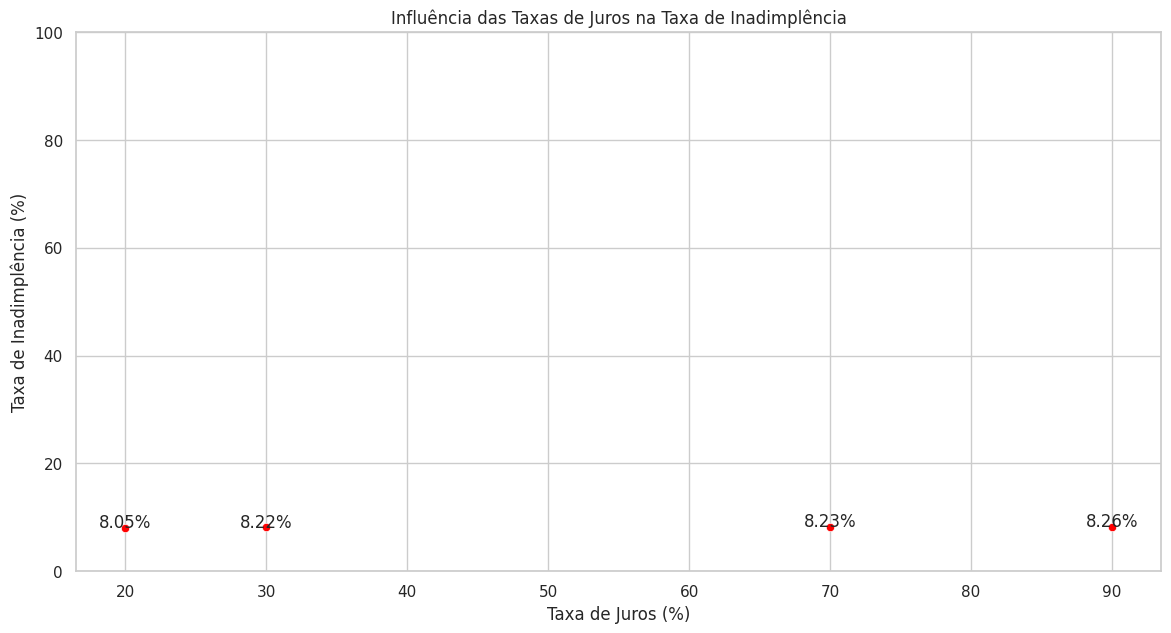

In [ ]:
# Influência das Taxas de Juros na Inadimplência
loans_data['is_default'] = loans_data['status'] == 'default'

# Calculando a taxa de inadimplência por taxa de juros
clients_loans = loans_data.merge(clients_data[['user_id', 'interest_rate']], on='user_id', how='left')
interest_default_rate = clients_loans.groupby('interest_rate').agg(
    total_loans=('loan_id', 'count'),
    default_loans=('is_default', 'sum')
).reset_index()
interest_default_rate['default_rate'] = interest_default_rate['default_loans'] / interest_default_rate['total_loans'] * 100  # Convertendo para porcentagem

# Plotando os resultados
plt.figure(figsize=(14, 7))
sns.scatterplot(x=interest_default_rate['interest_rate'], y=interest_default_rate['default_rate'], color='red')
plt.xlabel('Taxa de Juros (%)')
plt.ylabel('Taxa de Inadimplência (%)')
plt.title('Influência das Taxas de Juros na Taxa de Inadimplência')
plt.ylim(0, 100)  # Definindo os limites do eixo Y para 0 a 100%

# Adicionando rótulos nos pontos
for i, txt in enumerate(interest_default_rate['default_rate']):
    plt.annotate(f'{txt:.2f}%', (interest_default_rate['interest_rate'][i], interest_default_rate['default_rate'][i]), ha='center')

plt.show()


<ipython-input-8-5733e5eb4cd6>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loan_by_batch['batch'], y=mean_loan_by_batch['mean_loan_amount'], palette='Greens_d')


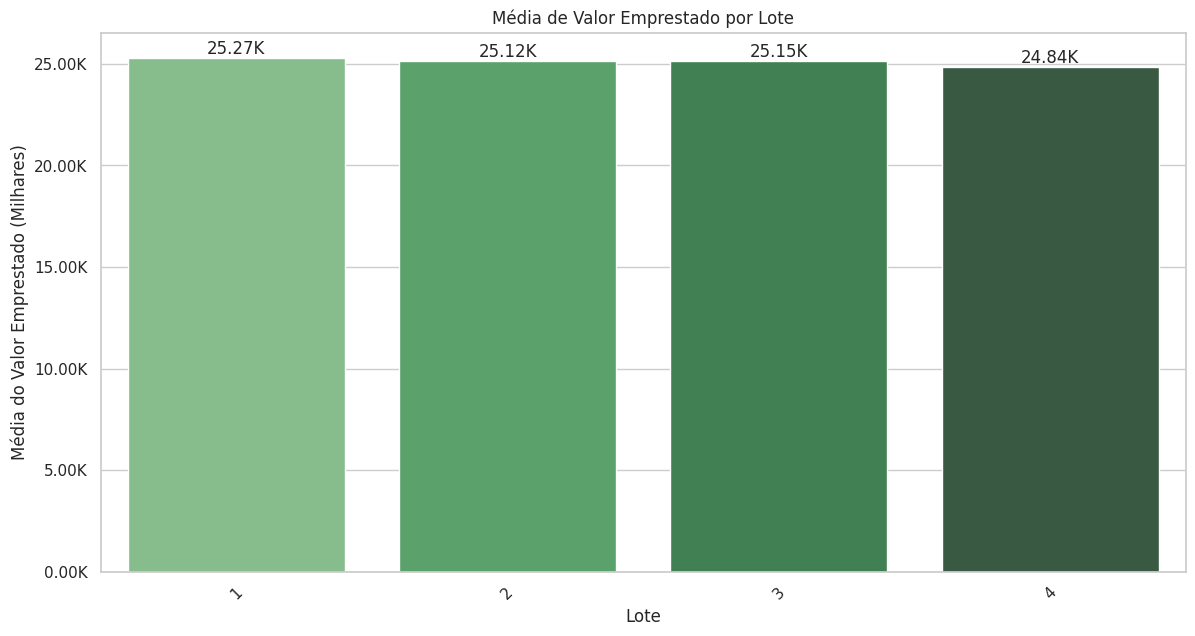

In [ ]:
# Média de Valor Emprestado por Lote

# Calculando a média do valor emprestado por lote
loan_by_batch = loans_data.merge(clients_data[['user_id', 'batch']], on='user_id', how='left')
mean_loan_by_batch = loan_by_batch.groupby('batch').agg(
    mean_loan_amount=('loan_amount', 'mean')
).reset_index()

# Função para formatar os valores em milhares
def thousands(x, pos):
    return '%1.2fK' % (x * 1e-3)

# Plotando os resultados
plt.figure(figsize=(14, 7))
sns.barplot(x=mean_loan_by_batch['batch'], y=mean_loan_by_batch['mean_loan_amount'], palette='Greens_d')
plt.xlabel('Lote')
plt.ylabel('Média do Valor Emprestado (Milhares)')
plt.title('Média de Valor Emprestado por Lote')
plt.xticks(rotation=45)

# Aplicando a formatação ao eixo Y
formatter = FuncFormatter(thousands)
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionando rótulos nas barras
for index, value in enumerate(mean_loan_by_batch['mean_loan_amount']):
    plt.text(index, value, f'{value * 1e-3:.2f}K', ha='center', va='bottom')

plt.show()


<ipython-input-6-419756c43165>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loan_by_interest['interest_rate'], y=mean_loan_by_interest['mean_loan_amount'], palette='Blues_d')


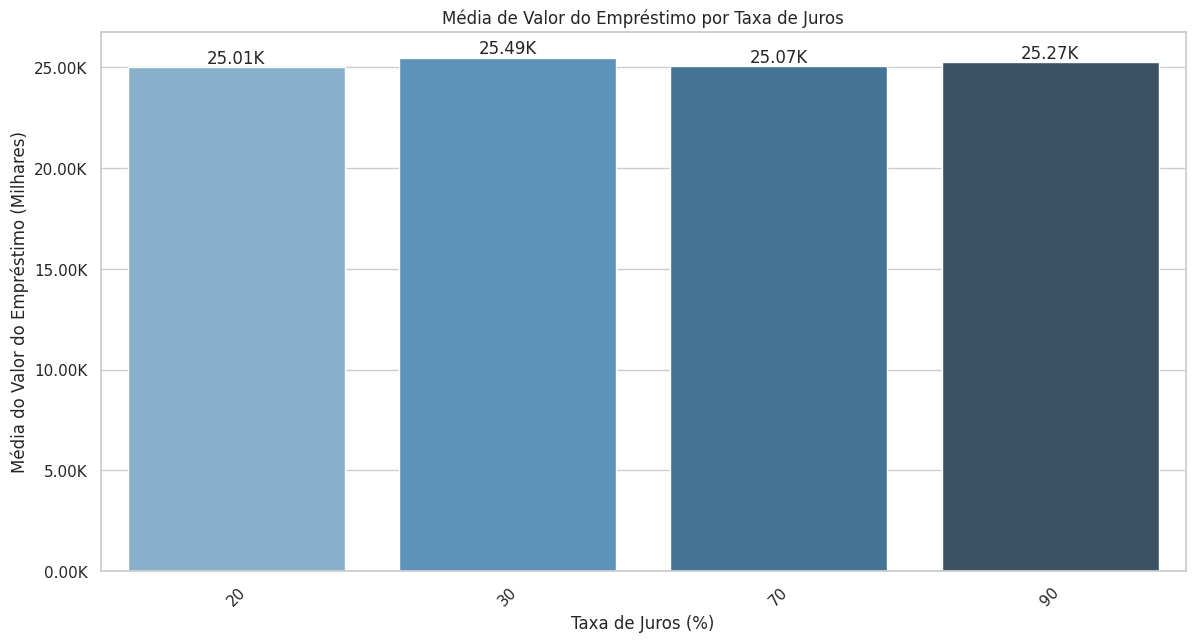

In [ ]:
# Média de Valor do Empréstimo por Taxa de Juros

# Calculando a média de valor do empréstimo por taxa de juros
mean_loan_by_interest = loans_data.merge(clients_data[['user_id', 'interest_rate']], on='user_id', how='left')
mean_loan_by_interest = mean_loan_by_interest.groupby('interest_rate').agg(
    mean_loan_amount=('loan_amount', 'mean')
).reset_index()

# Função para formatar os valores em milhares
def thousands(x, pos):
    return '%1.2fK' % (x * 1e-3)

# Plotando os resultados
plt.figure(figsize=(14, 7))
sns.barplot(x=mean_loan_by_interest['interest_rate'], y=mean_loan_by_interest['mean_loan_amount'], palette='Blues_d')
plt.xlabel('Taxa de Juros (%)')
plt.ylabel('Média do Valor do Empréstimo (Milhares)')
plt.title('Média de Valor do Empréstimo por Taxa de Juros')
plt.xticks(rotation=45)

# Aplicando a formatação ao eixo Y
formatter = FuncFormatter(thousands)
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionando rótulos nas barras
for index, value in enumerate(mean_loan_by_interest['mean_loan_amount']):
    plt.text(index, value, f'{value * 1e-3:.2f}K', ha='center', va='bottom')

plt.show()


In [ ]:
# Ranking de Clientes (10 melhores e 10 piores)

# Adicionando coluna de inadimplência
loans_data['is_default'] = loans_data['status'] == 'default'

# Calculando o valor em aberto para empréstimos inadimplentes
loans_data['default_amount'] = loans_data.apply(
    lambda row: row['due_amount'] - row['amount_paid'] if row['is_default'] else 0, axis=1)

# Agrupar dados dos clientes
clients_loan_summary = loans_data.groupby('user_id').agg(
    total_loan_amount=('loan_amount', 'sum'),
    total_amount_paid=('amount_paid', 'sum'),
    total_default_amount=('default_amount', 'sum')  # Valor em aberto se inadimplente
).reset_index()

# Classificando os melhores clientes (baseado na quantidade total de empréstimos pagos)
best_clients = clients_loan_summary.sort_values(by='total_amount_paid', ascending=False).head(10)

# Classificando os piores clientes (baseado no valor em aberto dos empréstimos não pagos)
worst_clients = clients_loan_summary[clients_loan_summary['total_default_amount'] > 0].sort_values(by='total_default_amount', ascending=False).head(10)

print("Top 10 Melhores Clientes:")
print(best_clients)
print("\nTop 10 Piores Clientes:")
print(worst_clients)


Top 10 Melhores Clientes:
       user_id  total_loan_amount  total_amount_paid  total_default_amount
60772    77087             513365          613098.35                   0.0
34819    44244             415316          499319.42                   0.0
48104    61144             452933          467963.71                   0.0
17708    22476             399699          446963.71                   0.0
22618    28742             386203          443752.85                   0.0
9276     11773             412470          439352.04                   0.0
29358    37345             418302          428164.32                   0.0
13614    17335             354517          428022.92                   0.0
5842      7429             411035          426986.42                   0.0
30223    38452             414343          422518.65                   0.0

Top 10 Piores Clientes:
       user_id  total_loan_amount  total_amount_paid  total_default_amount
52685    66899              96486            3345

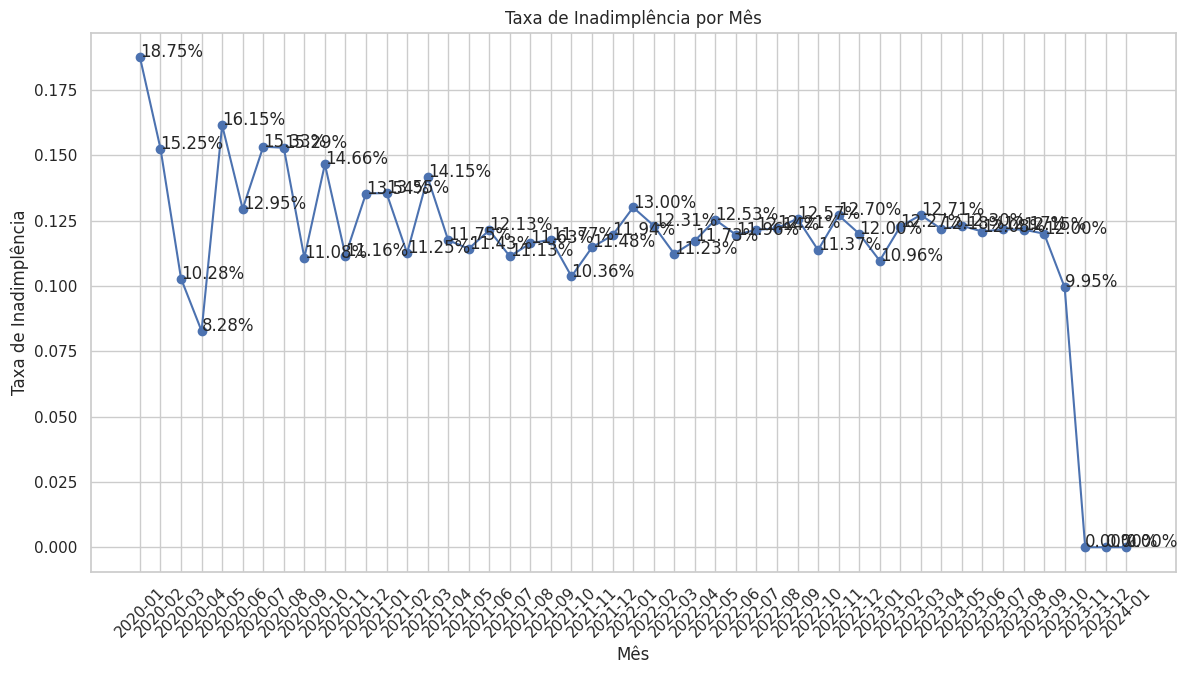

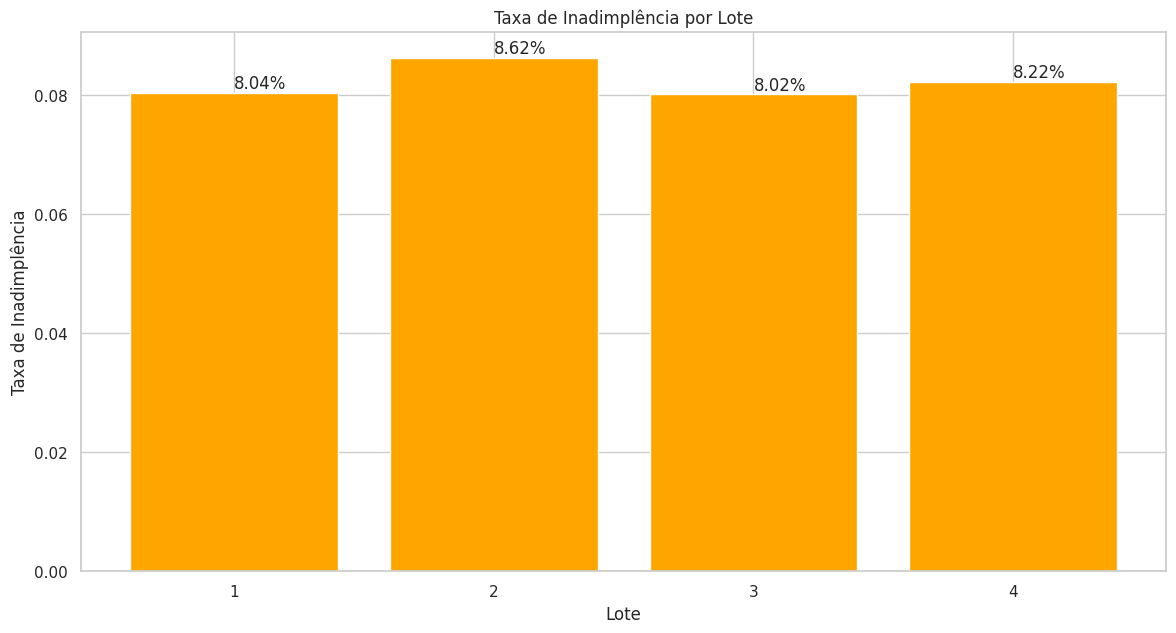

In [ ]:
# Taxa de Inadimplência por Mês e Lote
monthly_default_rate = loans_data.groupby('year_month').agg(
    total_loans=('loan_id', 'count'),
    default_loans=('is_default', 'sum')
).reset_index()
monthly_default_rate['default_rate'] = monthly_default_rate['default_loans'] / monthly_default_rate['total_loans']
clients_loans_by_batch = loans_data.merge(clients_data[['user_id', 'batch']], on='user_id', how='left')
batch_default_rate = clients_loans_by_batch.groupby('batch').agg(
    total_loans=('loan_id', 'count'),
    default_loans=('is_default', 'sum')
).reset_index()
batch_default_rate['default_rate'] = batch_default_rate['default_loans'] / batch_default_rate['total_loans']

plt.figure(figsize=(14, 7))
plt.plot(monthly_default_rate['year_month'].astype(str), monthly_default_rate['default_rate'], marker='o')
plt.xlabel('Mês')
plt.ylabel('Taxa de Inadimplência')
plt.title('Taxa de Inadimplência por Mês')
plt.xticks(rotation=45)

# Adicionando rótulos nos pontos
for i, txt in enumerate(monthly_default_rate['default_rate']):
    plt.annotate(f'{txt:.2%}', (monthly_default_rate['year_month'][i].strftime('%Y-%m'), txt))

plt.show()

plt.figure(figsize=(14, 7))
bars = plt.bar(batch_default_rate['batch'], batch_default_rate['default_rate'], color='orange')
plt.xlabel('Lote')
plt.ylabel('Taxa de Inadimplência')
plt.title('Taxa de Inadimplência por Lote')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Configurando o eixo X para mostrar apenas inteiros

# Adicionando rótulos nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', va='bottom')

plt.show()


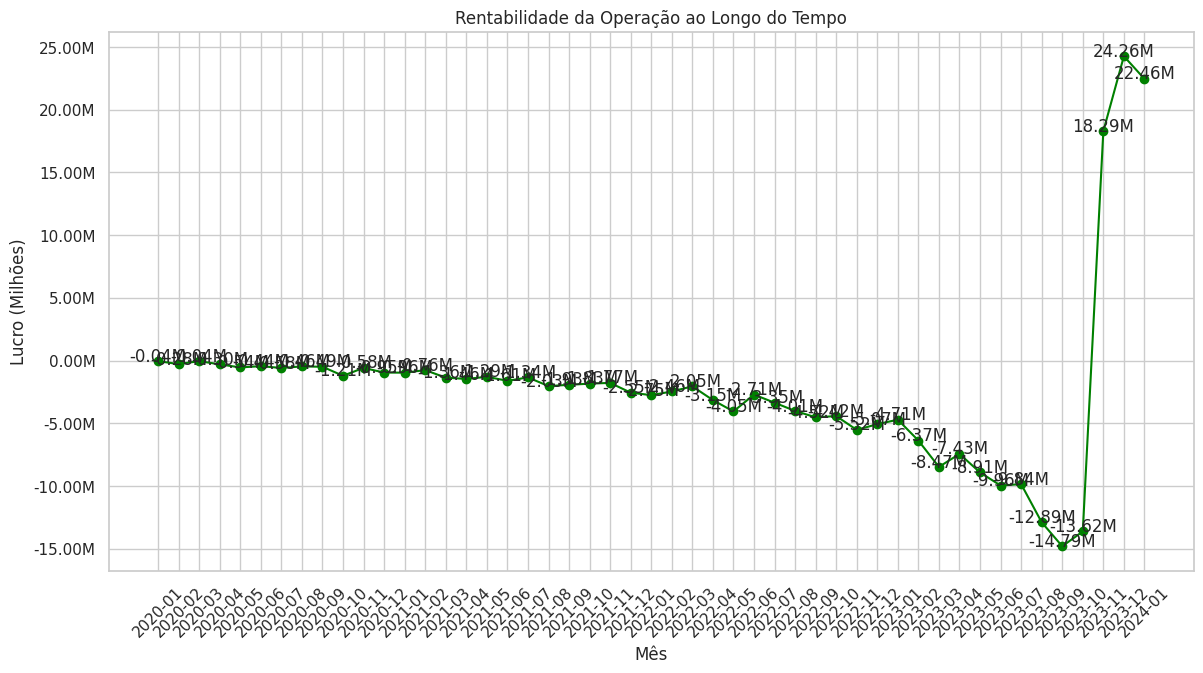

In [ ]:
# Calculando a receita de juros e perdas por inadimplência
clients_loans['interest_received'] = clients_loans['tax'] + ((clients_loans['loan_amount'] * clients_loans['interest_rate'] / 100) / 12)
clients_loans['default_loss'] = clients_loans['is_default'] * clients_loans['loan_amount']

# Agrupando por mês para calcular o lucro
monthly_profit = clients_loans.groupby('year_month').agg(
    total_interest_received=('interest_received', 'sum'),
    total_default_loss=('default_loss', 'sum')
).reset_index()
monthly_profit['profit'] = monthly_profit['total_interest_received'] - monthly_profit['total_default_loss']

# Função para formatar os valores em milhões
def millions(x, pos):
    return '%1.2fM' % (x * 1e-6)

# Plotando os resultados com a escala em milhões
plt.figure(figsize=(14, 7))
plt.plot(monthly_profit['year_month'].astype(str), monthly_profit['profit'], marker='o', color='green')
plt.xlabel('Mês')
plt.ylabel('Lucro (Milhões)')
plt.title('Rentabilidade da Operação ao Longo do Tempo')
plt.xticks(rotation=45)

# Aplicando a formatação ao eixo Y
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionando rótulos nos pontos
for i, txt in enumerate(monthly_profit['profit']):
    plt.annotate(f'{txt * 1e-6:.2f}M', (monthly_profit['year_month'][i].strftime('%Y-%m'), txt), ha='center')

plt.show()